In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from sklearn.model_selection import train_test_split

### Perform triangulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


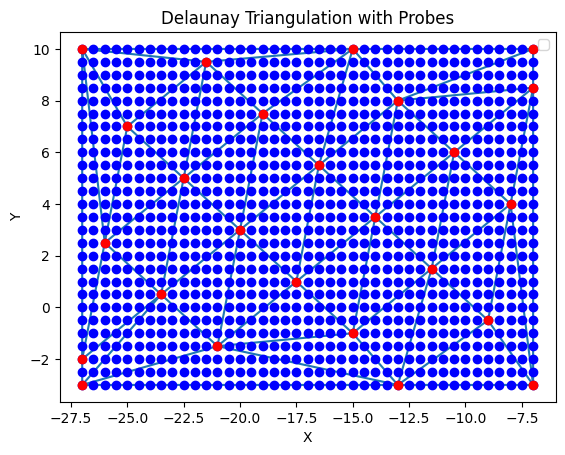

In [2]:
# Define scene area
x_min, x_max = -27, -7
y_min, y_max = -3, 10

# Desired number of probes (approximately 20)
num_probes = 24 # Adjust as needed (excluding corner probes)

# Generate valid grid points within the scene area
# x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
# valid_points = np.vstack((x_grid.flatten(), y_grid.flatten())).T

# Generate valid grid point within the scene area with step size 0.5
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max + 0.5, 0.5), np.arange(y_min, y_max + 0.5, 0.5))
valid_points = np.vstack((x_grid.flatten(), y_grid.flatten())).T

# Select corner probes explicitly
corner_probes = np.array([
    [x_min, y_min], [x_min, y_max], [x_max, y_min], [x_max, y_max]
])

# Select remaining probes (excluding corner probes) using slicing
remaining_points = valid_points[~np.isin(valid_points, corner_probes).all(axis=1)]
# exclude len(remaining_points) // (num_probes - 4) points from the start point
exc = int((len(remaining_points) // (num_probes - 4)) / 2)
remaining_points = remaining_points[exc:]

remaining_probes = remaining_points[::len(remaining_points) // (num_probes - 4)]

# Combine corner and remaining probes
probes = np.concatenate((corner_probes, remaining_probes))

# # Print probe locations
# print("Probe locations:")
# for probe in probes:
#     print(f"  x: {probe[0]}, y: {probe[1]}")

# Perform Delaunay triangulation
tri = Delaunay(probes)

# Plot the triangulation with probes and valid points
plt.triplot(probes[:, 0], probes[:, 1], tri.simplices)
plt.plot(valid_points[:, 0], valid_points[:, 1], 'bo')
plt.plot(probes[:, 0], probes[:, 1], 'ro')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation with Probes')
plt.legend()
plt.show()

In [3]:
def get_containing_triangle(point, probes, tri):
  """
  This function finds the triangle containing a given point using the Delaunay triangulation.

  Args:
      point: A numpy array representing the point (x, y) coordinates.
      probes: A numpy array containing the probe locations.
      tri: A Delaunay triangulation object from scipy.spatial.Delaunay.

  Returns:
      A numpy array containing the vertices of the triangle that contains the point, 
      or None if the point is outside the convex hull of the probes.
  """
  # Use the `find_simplex` method of the Delaunay triangulation
  simplex_index = tri.find_simplex(point)

  # Check if the point is outside the convex hull
  if simplex_index == -1:
    return None

  # Get the vertices of the containing triangle
  return probes[tri.simplices[simplex_index]]

# Example usage:
# Select a valid point (modify this to your desired point)
valid_point = valid_points[10]  # Replace with your specific valid point coordinates

# Find the containing triangle
containing_triangle = get_containing_triangle(valid_point, probes, tri)

if containing_triangle is None:
  print("Point is outside the convex hull of the probes.")
else:
  print("Point", valid_point, "is located in triangle:")
  print(containing_triangle)


Point [-22.  -3.] is located in triangle:
[[-13.   -3. ]
 [-21.   -1.5]
 [-27.   -3. ]]


In [4]:
def get_barycentric_weights(point, triangle):
    # Extract triangle vertices
    x1, y1 = triangle[0]
    x2, y2 = triangle[1]
    x3, y3 = triangle[2]
    
    # Calculate vectors
    v0 = np.array([x3 - x1, y3 - y1])
    v1 = np.array([x2 - x1, y2 - y1])
    v2 = np.array([point[0] - x1, point[1] - y1])
    
    # Calculate dot products
    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)
    
    # Calculate barycentric weights
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom
    w = 1 - u - v
    
    return np.array([w, v, u])


valid_point = valid_points[10]  # Replace with your specific valid point coordinates
valid_point = np.array([-18, 9])
containing_triangle = get_containing_triangle(valid_point, probes, tri)

# Example usage (assuming you have a containing triangle from previous step)
if containing_triangle is not None:
  barycentric_weights = get_barycentric_weights(valid_point, containing_triangle)
  print("Barycentric weights of", valid_point, "in the triangle:")
  print(barycentric_weights)
  print("triangle: ", containing_triangle)

Barycentric weights of [-18   9] in the triangle:
[0.24561404 0.35087719 0.40350877]
triangle:  [[-21.5   9.5]
 [-19.    7.5]
 [-15.   10. ]]


In [5]:
# generate bilinear interpolated images
def bi_linear_interpolate(img1, img2, img3, barycentric_coords):
    # Extract barycentric coordinates
    b1, b2, b3 = barycentric_coords

    # Compute the size of the output image
    out_shape = img1.shape[:-1]

    # Create an empty array to hold the output image
    out_img = np.zeros(out_shape + (4,))

    for i in range(out_img.shape[0]):
        for j in range(out_img.shape[1]):
            # Extract pixels from each image
            pixel1 = img1[i, j]
            pixel2 = img2[i, j]
            pixel3 = img3[i, j]

            # Interpolate using barycentric coordinates
            new_pixel = b1 * pixel1 + b2 * pixel2 + b3 * pixel3
            out_img[i, j] = new_pixel

    return out_img

# Example usage
# n = 1000
# valid_point = valid_points[n]  # Replace with your specific valid point coordinates
# containing_triangle = get_containing_triangle(valid_point, probes, tri)
# if containing_triangle is not None:
#     barycentric_weights = get_barycentric_weights(valid_point, containing_triangle)
#     interpolated_image = bi_linear_interpolate(images[n][0], images[n][1], images[n][2], barycentric_weights)
#     plt.imshow(interpolated_image)
#     plt.title("Bilinear Interpolated Image")
#     plt.axis('off')
#     plt.show()
#     # show ground truth image
#     plt.imshow(images_interpolated[n])
#     plt.title("Ground Truth Image")
#     plt.axis('off')
#     plt.show()

### Neural network

In [6]:
# Preprocess the data
barycentric_coords = []
images = []
depth_images = []
bilinear_images = []
z = 1.7
for point in valid_points:
    containing_triangle = get_containing_triangle(point, probes, tri)
    if containing_triangle is not None:
        barycentric_weights = get_barycentric_weights(point, containing_triangle)
        barycentric_coords.append(barycentric_weights)

        # coresponding images are located in triangle's vertices
        image1_name = f"camera_{containing_triangle[0][0]}_{containing_triangle[0][1]}_{z} image0001.png"
        image2_name = f"camera_{containing_triangle[1][0]}_{containing_triangle[1][1]}_{z} image0001.png"
        image3_name = f"camera_{containing_triangle[2][0]}_{containing_triangle[2][1]}_{z} image0001.png"
        
        depth1_name = f"camera_{containing_triangle[0][0]}_{containing_triangle[0][1]}_{z} depth0001.png"
        depth2_name = f"camera_{containing_triangle[1][0]}_{containing_triangle[1][1]}_{z} depth0001.png"
        depth3_name = f"camera_{containing_triangle[2][0]}_{containing_triangle[2][1]}_{z} depth0001.png"

        # open images and get the pixel values
        dir = "./DepthImages_new/"
        image1 = plt.imread(dir + image1_name)
        image2 = plt.imread(dir + image2_name)
        image3 = plt.imread(dir + image3_name)

        depth1 = plt.imread(dir + depth1_name)
        depth2 = plt.imread(dir + depth2_name)
        depth3 = plt.imread(dir + depth3_name)

        # add bilinear interpolated images
        bilinear_image = bi_linear_interpolate(image1, image2, image3, barycentric_weights)


        # delete alpha channel
        #image1 = image1[:, :, :3]
        #image2 = image2[:, :, :3]
        #image3 = image3[:, :, :3]

        #depth1 = depth1[:, :, :3]
        #depth2 = depth2[:, :, :3]
        #depth3 = depth3[:, :, :3]

        images.append([image1, image2, image3])
        depth_images.append([depth1, depth2, depth3])
        bilinear_images.append(bilinear_image)



# ground truth images
images_ground_truth= []
for point in valid_points:
    image_name = f"camera_{point[0]}_{point[1]}_{z} image0001.png"
    image = plt.imread(dir + image_name)
    # image = image[:, :, :3]
    images_ground_truth.append(image)

images_ground_truth = np.array(images_ground_truth)
print(images_ground_truth.shape)

# Convert lists to numpy arrays	
barycentric_coords = np.array(barycentric_coords)
print(barycentric_coords.shape)

images_train = np.array(images)
print(images_train.shape)

bilinear_images = np.array(bilinear_images)

print(bilinear_images.shape)

(1107, 256, 256, 4)
(1107, 3)
(1107, 3, 256, 256, 4)
(1107, 256, 256, 4)


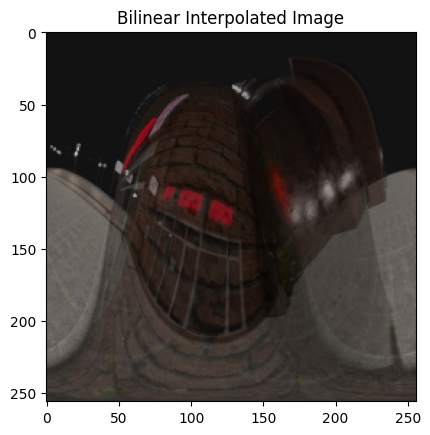

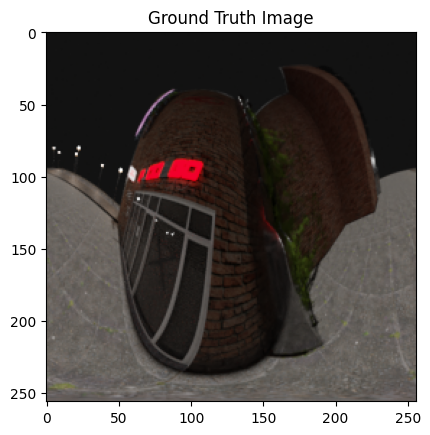

In [14]:
n = 120
# show an example of bilinear interpolated image
plt.imshow(bilinear_images[n])
plt.title("Bilinear Interpolated Image")
plt.show()
# show ground truth image
plt.imshow(images_ground_truth[n])
plt.title("Ground Truth Image")
plt.show()

In [7]:
# Train test split

# Split the data into train and temp sets
# barycentric_train_temp, barycentric_test, images_train_temp, images_test, images_interpolated_train_temp, images_interpolated_test = train_test_split(barycentric_coords, images, images_interpolated, test_size=0.2, random_state=42)
# include also depth images and bilinear images
barycentric_train_temp, barycentric_test, images_train_temp, images_test, depth_images_train_temp, depth_images_test, bilinear_images_train_temp, bilinear_images_test, images_ground_truth_train_temp, images_ground_truth_test = train_test_split(barycentric_coords, images, depth_images, bilinear_images, images_ground_truth, test_size=0.2, random_state=42)

#barycentric_train_temp, barycentric_test, images_train_temp, images_test, images_ground_truth_train_temp, images_ground_truth_test, depth_images_train_temp, depth_images_test = train_test_split(barycentric_coords, images, images_ground_truth, depth_images, test_size=0.2, random_state=42)


# Split the temp set into train and validation sets
barycentric_train, barycentric_val, images_train, images_val, depth_images_train, depth_images_val, bilinear_images_train, bilinear_images_val, images_ground_truth_train, images_ground_truth_val = train_test_split(barycentric_train_temp, images_train_temp, depth_images_train_temp, bilinear_images_train_temp, images_ground_truth_train_temp, test_size=0.25, random_state=42)
# barycentric_train, barycentric_val, images_train, images_val, images_interpolated_train, images_interpolated_val, depth_images_train, depth_images_val = train_test_split(barycentric_train_temp, images_train_temp, images_interpolated_train_temp, depth_images_train_temp, test_size=0.2, random_state=42)
#barycentric_train, barycentric_val, images_train, images_val, images_interpolated_train, images_interpolated_val = train_test_split(barycentric_train_temp, images_train_temp, images_interpolated_train_temp, test_size=0.25, random_state=42)
# barycentric_train, barycentric_val, images_train, images_val, images_ground_truth_train, images_ground_truth_val, depth_images_train, depth_images_val = train_test_split(barycentric_train_temp, images_train_temp, images_ground_truth_train_temp, depth_images_train_temp, test_size=0.25, random_state=42)

# convert all to numpy arrays
barycentric_train = np.array(barycentric_train)
barycentric_val = np.array(barycentric_val)
barycentric_test = np.array(barycentric_test)

images_train = np.array(images_train)
images_val = np.array(images_val)
images_test = np.array(images_test)

images_ground_truth_train = np.array(images_ground_truth_train)
images_ground_truth_val = np.array(images_ground_truth_val)
images_ground_truth_test = np.array(images_ground_truth_test)

depth_images_train = np.array(depth_images_train)
depth_images_val = np.array(depth_images_val)
depth_images_test = np.array(depth_images_test)

images_ground_truth_train = np.array(images_ground_truth_train)
images_ground_truth_val = np.array(images_ground_truth_val)
images_ground_truth_test = np.array(images_ground_truth_test)

print(images_ground_truth_train.shape)
print(images_ground_truth_val.shape)
print(images_ground_truth_test.shape)

print(bilinear_images_train.shape)
print(bilinear_images_val.shape)
print(bilinear_images_test.shape)



# barycentric_train, barycentric_val, barycentric_test now contain the barycentric coordinates for training, validation, and testing respectively
# images_train, images_val, images_test now contain the corresponding images
# images_interpolated_train, images_interpolated_val, images_interpolated_test now contain the corresponding ground truth interpolated images

(663, 256, 256, 4)
(222, 256, 256, 4)
(222, 256, 256, 4)
(663, 256, 256, 4)
(222, 256, 256, 4)
(222, 256, 256, 4)


In [8]:
import tensorflow as tf
from keras import layers, models

def create_model_bilinear(input_shape_1, input_shape_2):
    # Input layers
    input_interpolated_image = layers.Input(shape=input_shape_1, name='interpolated_image') # shape (256, 256, 4)
    input_rgba_images = layers.Input(shape=input_shape_2, name='rgba_images') # shape (3, 256, 256, 4)
    input_depth_images = layers.Input(shape=input_shape_2, name='depth_images') # shape (3, 256, 256, 4)
    # shape_2 = (3, 256, 256, 4)



    # Concatenate RGBA and depth images along the channel dimension for each vertex
    concatenated_images = []
    for i in range(3):
        rgba_image = input_rgba_images[:, i, :, :, :]
        # depth_image = input_depth_images[:, i, :, :, :]
        concatenated_images.append(layers.Concatenate(axis=-1)([rgba_image]))

    # Concatenate all concatenated images along the channel dimension
    input_concatenated_images = layers.Concatenate(axis=-1)(concatenated_images)

    # Concatenate input interpolated image and concatenated images
    merged_input = layers.Concatenate(axis=-1)([input_interpolated_image, input_concatenated_images])

    # Define the convolutional layers
    conv_output = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(merged_input)
    conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
    conv_output = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
    conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
    conv_output = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
    conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
    conv_output = layers.Flatten()(conv_output)

    # Interpolation
    x = layers.Dense(1024, activation='relu')(conv_output)
    x = layers.Reshape((16, 16, 4))(x)  # Change to 4 channels
    x = layers.Conv2DTranspose(filters=512, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=32, kernel_size=(4, 4), activation='relu', strides=(1, 1), padding='same')(x)
    x = layers.Conv2D(filters=4, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)

    # Output
    output = layers.Conv2D(filters=4, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)

    # Define inputs and outputs
    inputs = [input_interpolated_image, input_rgba_images, input_depth_images]
    model = models.Model(inputs=inputs, outputs=output)

    return model

# Example usage
input_shape_1 = (256, 256, 4) 
input_shape_2 = (3, 256, 256, 4) 
model = create_model_bilinear(input_shape_1, input_shape_2)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgba_images         │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256,  │          0 │ rgba_images[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256,  │          0 │ rgba_images[0][0] │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256,  │          0 │ rgba_images[0][0] │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ get_item[0][0]    │
│ (Concatenate)       │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ get_item_1[0][0]  │
│ (Concatenate)       │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256, 256,  │          0 │ get_item_2[0][0]  │
│ (Concatenate)       │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ interpolated_image  │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 12)               │            │ concatenate_1[0]… │
│                     │                   │            │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256, 256,  │          0 │ interpolated_ima… │
│ (Concatenate)       │ 16)               │            │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │     32,896 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │    524,544 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │  2,097,664 │ max_pooling2d_1[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 542,348,392 (2.02 GB)

 Trainable params: 542,348,392 (2.02 GB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from keras import config, callbacks
import tensorflow as tf


callback = callbacks.EarlyStopping(monitor='loss', patience=3)

# interpolation_model.compile(optimizer='adam', loss=custom_loss)
# use adamW optimizer
model.compile(
    optimizer= 'adam',
    loss='mse',
    metrics=[
        'MeanSquaredError',
    ]
)
# mean absolute
# cross entropy loss

batch_size = 32
num_epochs = 2


# model.compile(optimizer='adam', loss=custom_loss)
config.disable_traceback_filtering()
print("Training model...")
print(bilinear_images_train.shape)
print(images_train.shape)
print(depth_images_train.shape)
# Train the model
history = model.fit(
    {
        'interpolated_image': bilinear_images_train,
        'rgba_images': images_train,
        'depth_images': depth_images_train
    },
    images_ground_truth_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(
        {
            'interpolated_image': bilinear_images_val,
            'rgba_images': images_val,
            'depth_images': depth_images_val
        },
        images_ground_truth_val
    ),
    callbacks=[callback]
)

Training model...
(663, 256, 256, 4)
(663, 3, 256, 256, 4)
(663, 3, 256, 256, 4)
Epoch 1/2
21/21 ━━━━━━━━━━━━━━━━━━━━ 577s 25s/step - MeanSquaredError: 0.1329 - loss: 0.1329 - val_MeanSquaredError: 0.0521 - val_loss: 0.0521
Epoch 2/2
21/21 ━━━━━━━━━━━━━━━━━━━━ 518s 25s/step - MeanSquaredError: 0.0381 - loss: 0.0381 - val_MeanSquaredError: 0.0194 - val_loss: 0.0194


7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step


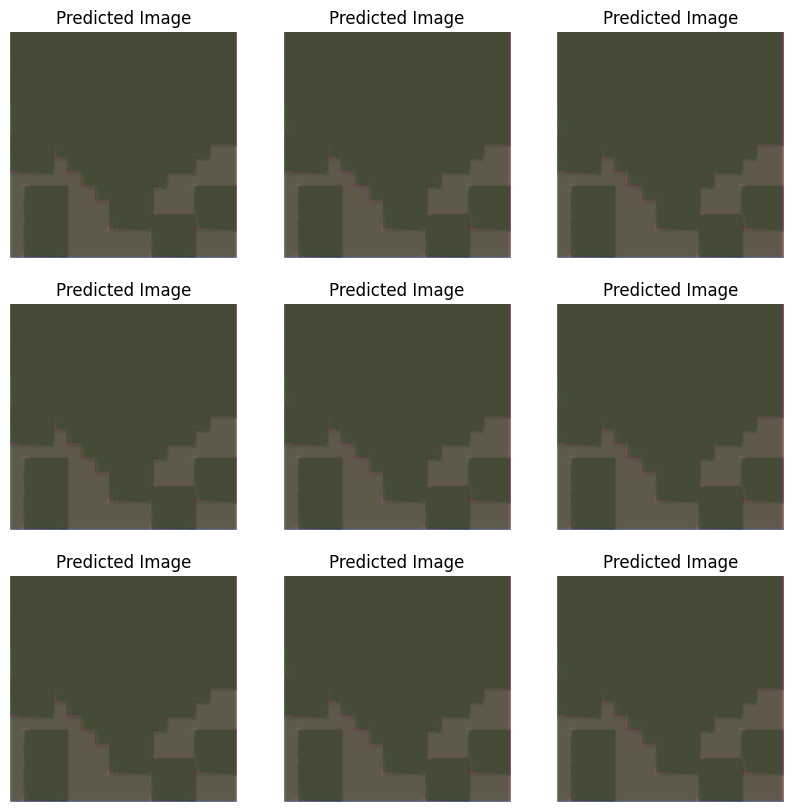

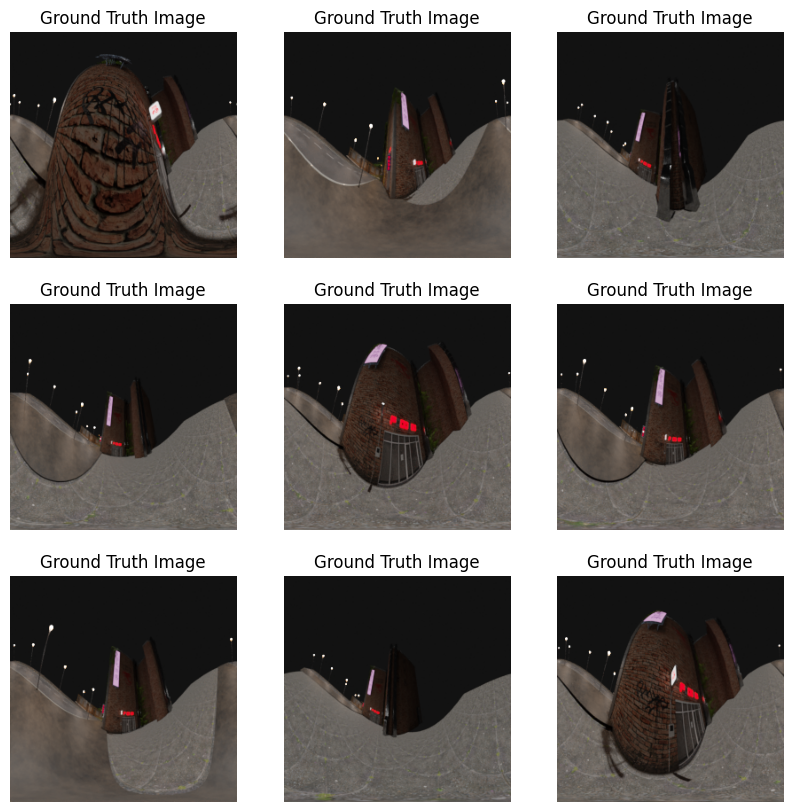

In [11]:

# Predict the interpolated images
predicted_images = model.predict([bilinear_images_test, images_test, depth_images_test])

# Plot the predicted and ground truth images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(predicted_images[i])
    plt.axis('off')
    plt.title('Predicted Image')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_ground_truth_test[i])
    plt.axis('off')
    plt.title('Ground Truth Image')
plt.show()

In [7]:
import tensorflow as tf
from keras import layers, models

# Define loss function
def custom_loss(y_true, y_pred):
    return tf.keras.losses.MSE(y_true, y_pred)

# print shapes
# print(barycentric_train.shape)
# print(images_train.shape)
# print(images_interpolated_train.shape)
# print(barycentric_val.shape)
# print(images_val.shape)
# print(images_interpolated_val.shape)

In [9]:
from keras import layers, models

def create_model(input_shape):
    input_coords = layers.Input(shape=(3,))
    input_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
    # Separate convolutional layers for processing each image
    conv_outputs = []
    for i in range(3):
        conv_output = layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding="valid")(input_images[:, i, :, :, :])
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding="valid")(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding="valid")(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=512, kernel_size=(5, 5), activation='relu', padding="valid")(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=1024, kernel_size=(5, 5), activation='relu', padding="valid")(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_outputs.append(conv_output)
    cnn_output = layers.Concatenate()(conv_outputs)

    
    # send barycentric coordinates through 4 Dense layers so that we get 
    # 384 output neurons
    coords = layers.Dense(64, activation='relu')(input_coords)
    coords = layers.Dense(128, activation='relu')(coords)
    coords = layers.Dense(256, activation='relu')(coords)
    coords = layers.Dense(384, activation='relu')(coords)

    # reshape to (1, 3, 16, 8)
    coords = layers.Reshape((4, 4, 24))(coords)
    # run convolutional layer without upsampling
    coords = layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same')(coords)
    coords = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(coords)
    coords = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(coords)
    coords = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(coords)
    coords = layers.Conv2D(filters=1024, kernel_size=(4, 4), activation='relu', padding='same')(coords)

    # Tile coords to match the spatial dimensions of cnn_output
    # coords = layers.Lambda(lambda x: tf.tile(x, [1, tf.shape(cnn_output)[1], tf.shape(cnn_output)[2], 1]))(coords)

    # Combine the intermediate CNN outputs
    merged_output = layers.Concatenate(axis=-1)([cnn_output, coords])
    
    x = layers.Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same')(merged_output)
    x = layers.UpSampling2D(size=(2, 2))(x)
    
    x = layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    
    x = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

    x = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

    x = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    
    x = layers.Conv2D(filters=4, kernel_size=(4, 4), activation='relu', padding='same')(x)

    # x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)

    
    model = models.Model(inputs=[input_coords, input_images], outputs=x)
    return model

input_shape = (3, 256, 256, 4)

model_15 = create_model(input_shape)
model_15.summary()
#model.compile(optimizer='adam', loss=custom_loss)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (GetItem)           │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 252, 252,  │      6,464 │ get_item_3[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 252, 252,  │      6,464 │ get_item_4[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 252, 252,  │      6,464 │ get_item_5[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 126, 126,  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 126, 126,  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 126, 126,  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 122, 122,  │    204,928 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 122, 122,  │    204,928 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 122, 122,  │    204,928 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 61, 61,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 72,668,132 (277.21 MB)

 Trainable params: 72,668,132 (277.21 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras import config, callbacks
import tensorflow as tf


callback = callbacks.EarlyStopping(monitor='loss', patience=3)

# interpolation_model.compile(optimizer='adam', loss=custom_loss)
# use adamW optimizer
model_15.compile(
    optimizer= 'adamW',
    loss='mse',
)
# mean absolute
# cross entropy loss

batch_size = 32
num_epochs = 3


# model.compile(optimizer='adam', loss=custom_loss)
# config.disable_traceback_filtering()
# Train the model
model_15.fit([barycentric_train, images_train], images_ground_truth_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val], images_ground_truth_val), callbacks=[callback])
#model_15.fit([barycentric_train, images_train, depth_images_train], images_ground_truth_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val, depth_images_val], images_ground_truth_val), callbacks=[callback])


Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 1704s 81s/step - loss: 10665.5527 - val_loss: 0.1901
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 1726s 83s/step - loss: 0.1141 - val_loss: 0.0590
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 1629s 78s/step - loss: 0.0561 - val_loss: 0.0545


7/7 ━━━━━━━━━━━━━━━━━━━━ 115s 16s/step - loss: 0.0539
Test Loss: 0.053320545703172684
7/7 ━━━━━━━━━━━━━━━━━━━━ 133s 19s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


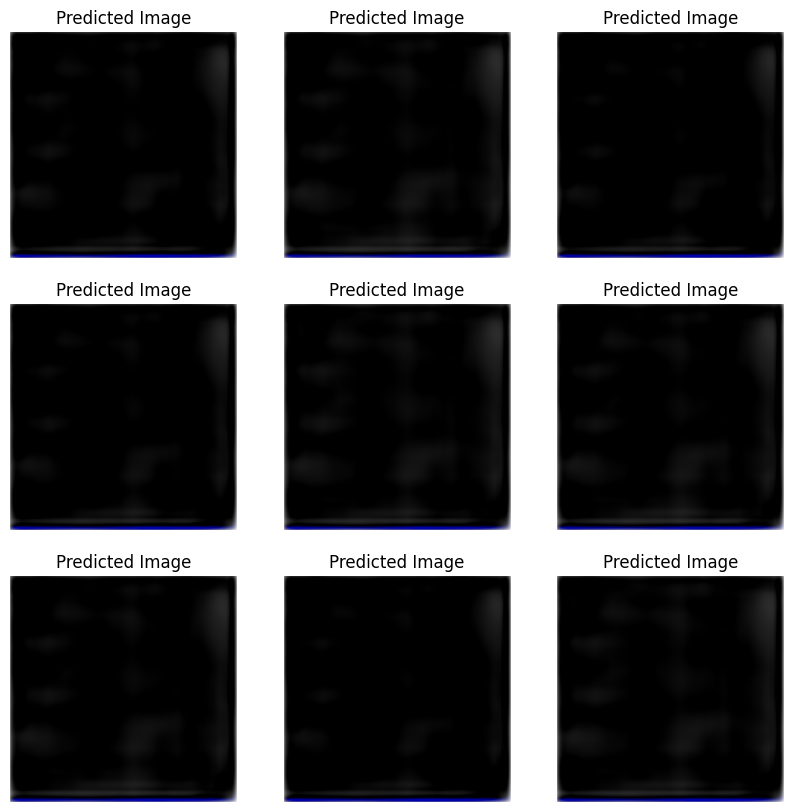

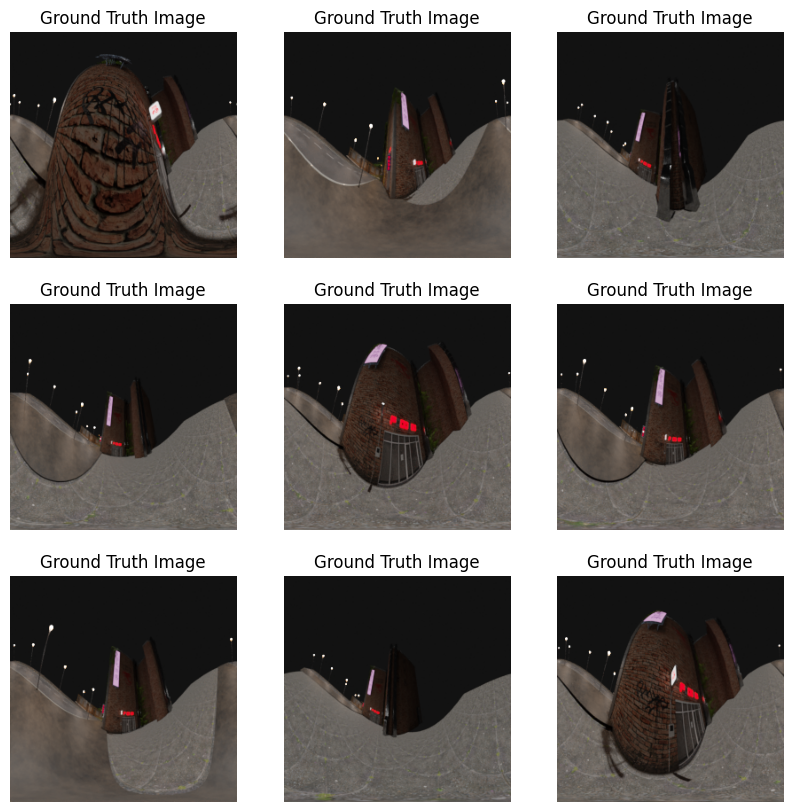

In [11]:

# Evaluate the model
loss = model_15.evaluate([barycentric_test, images_test], images_ground_truth_test)
print("Test Loss:", loss)

# Predict the interpolated images
predicted_images = model_15.predict([barycentric_test, images_test])

# Plot the predicted and ground truth images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(predicted_images[i])
    plt.axis('off')
    plt.title('Predicted Image')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_ground_truth_test[i])
    plt.axis('off')
    plt.title('Ground Truth Image')
plt.show()


In [7]:
from keras import layers, models

def build_interpolation_model(input_shape):
    # Input layers
    input_coords = layers.Input(shape=(3,))
    input_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
    # Image Processing Branch
    conv_outputs = []
    for i in range(3):
        conv_output = input_images[:, i, :, :, :]
        conv_output = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Flatten()(conv_output)
        conv_outputs.append(conv_output)
    cnn_output = layers.Concatenate()(conv_outputs)
    
    # Barycentric Coordinates Processing Branch
    x = layers.Dense(64, activation='relu')(input_coords)
    x = layers.Dense(32, activation='relu')(x)
    
    # Combining both branches
    merged_output = layers.Concatenate()([cnn_output, x])
    
    # Interpolation
    x = layers.Dense(1024, activation='relu')(merged_output)
    x = layers.Reshape((16, 16, 4))(x)  # Change to 4 channels
    x = layers.Conv2DTranspose(filters=512, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=32, kernel_size=(4, 4), activation='relu', strides=(1, 1), padding='same')(x)
    x = layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), activation='linear', strides=(1, 1), padding='same')(x)
    
    # Output
    output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
    # Creating model
    model = models.Model(inputs=[input_coords, input_images], outputs=output)
    return model



def build_interpolation_model_depth(input_shape):
    # Input layers
    input_coords = layers.Input(shape=(3,))
    input_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    depth_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)

    # Image Processing Branch
    conv_outputs = []
    conv_outputs_depth = []
    for i in range(3):
        conv_output = input_images[:, i, :, :, :]
        conv_output = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Flatten()(conv_output)
        conv_outputs.append(conv_output)

        # Depth Image Processing Branch
        conv_output_depth = depth_images[:, i, :, :, :]
        conv_output_depth = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Flatten()(conv_output_depth)
        conv_outputs_depth.append(conv_output_depth)
        
    cnn_output = layers.Concatenate()(conv_outputs)
    cnn_output_depth = layers.Concatenate()(conv_outputs_depth)
    
    # Barycentric Coordinates Processing Branch
    x = layers.Dense(64, activation='relu')(input_coords)
    x = layers.Dense(32, activation='relu')(x)
    
    # Combining both branches
    merged_output = layers.Concatenate()([cnn_output, cnn_output_depth, x])
    
    x = layers.Dense(512, activation='relu')(merged_output)
    x = layers.Reshape((16, 16, 2))(x)  # Change to 4 channels
    x = layers.Conv2DTranspose(filters=512, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=32, kernel_size=(4, 4), activation='relu', strides=(1, 1), padding='same')(x)
    x = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)


    # Output
    output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
    # Creating model
    model = models.Model(inputs=[input_coords, input_images, depth_images], outputs=output)
    return model


# Define image dimensions
image_height, image_width, num_channels = 256, 256, 3

# Define number of epochs and batch size
num_epochs = 10
batch_size = 32

# Create the model
input_shape = (3, image_height, image_width, num_channels)

# Build the model
#interpolation_model = build_interpolation_model(input_shape)
#interpolation_model.summary()
interpolation_model_depth = build_interpolation_model_depth(input_shape)
interpolation_model_depth.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      6,272 │ get_item[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │      6,272 │ get_item_2[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │      6,272 │ get_item_4[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      6,272 │ get_item_1[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      6,272 │ get_item_3[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │      6,272 │ get_item_5[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_12[0][0] 

 Total params: 1,629,207,190 (6.07 GB)

 Trainable params: 1,629,207,190 (6.07 GB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from keras import config, callbacks
import tensorflow as tf


callback = callbacks.EarlyStopping(monitor='loss', patience=3)

# interpolation_model.compile(optimizer='adam', loss=custom_loss)
# use adamW optimizer
interpolation_model_depth.compile(
    optimizer= 'adam',
    loss='mse',
    metrics=[
        'MeanSquaredError',
    ]
)
# mean absolute
# cross entropy loss

batch_size = 8
num_epochs = 5


# model.compile(optimizer='adam', loss=custom_loss)
# config.disable_traceback_filtering()
# Train the model
# interpolation_model.fit([barycentric_train, images_train], images_interpolated_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val], images_interpolated_val), callbacks=[callback])
interpolation_model_depth.fit([barycentric_train, images_train, depth_images_train], images_ground_truth_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val, depth_images_val], images_ground_truth_val), callbacks=[callback])


Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 7602s 91s/step - MeanSquaredError: 0.0446 - loss: 0.0446 - val_MeanSquaredError: 0.0061 - val_loss: 0.0061
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 6748s 80s/step - MeanSquaredError: 0.0062 - loss: 0.0062 - val_MeanSquaredError: 0.0051 - val_loss: 0.0051
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 6248s 75s/step - MeanSquaredError: 0.0052 - loss: 0.0052 - val_MeanSquaredError: 0.0045 - val_loss: 0.0045
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 6698s 81s/step - MeanSquaredError: 0.0047 - loss: 0.0047 - val_MeanSquaredError: 0.0045 - val_loss: 0.0045
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 5891s 71s/step - MeanSquaredError: 0.0048 - loss: 0.0048 - val_MeanSquaredError: 0.0042 - val_loss: 0.0042


ValueError: Layer 'functional_1' expected 3 input(s). Received 2 instead.

7/7 ━━━━━━━━━━━━━━━━━━━━ 104s 15s/step - MeanSquaredError: 0.0042 - loss: 0.0042
Test Loss: [0.004341589752584696, 0.0043415892869234085]
7/7 ━━━━━━━━━━━━━━━━━━━━ 108s 16s/step


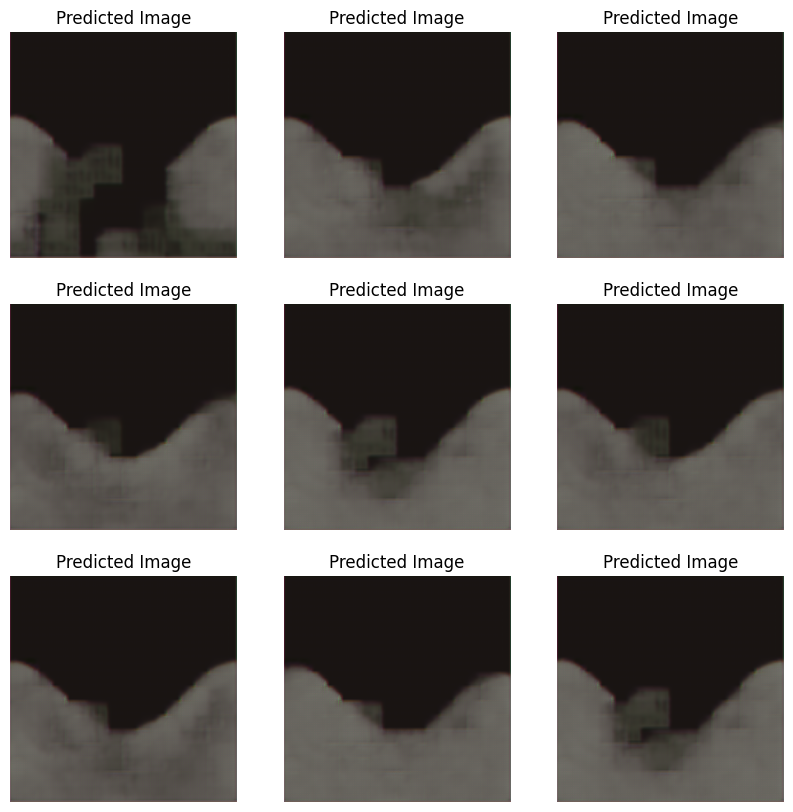

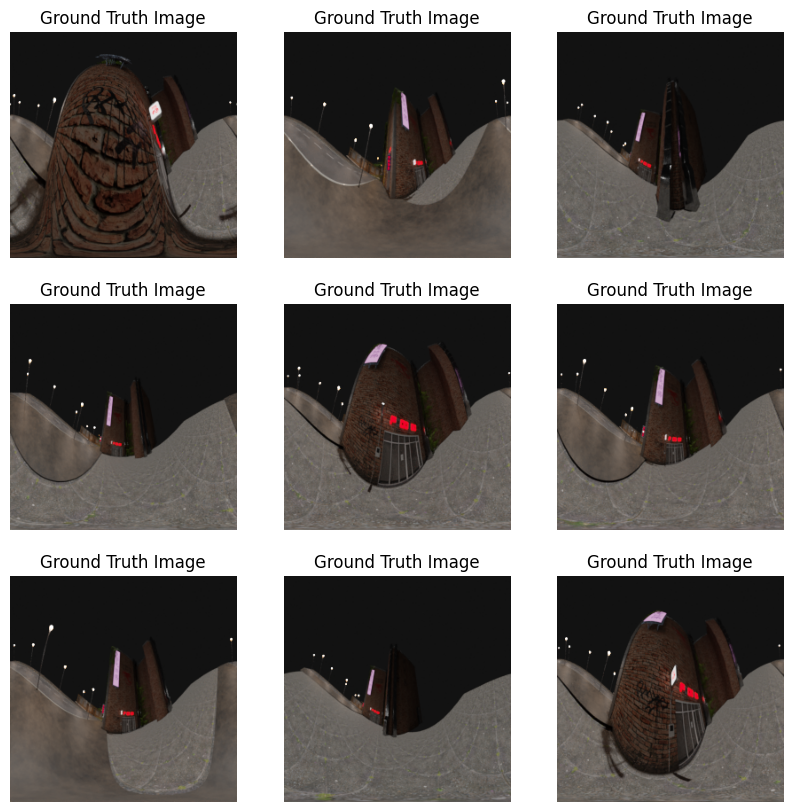

In [10]:

# Evaluate the model
loss = interpolation_model_depth.evaluate([barycentric_test, images_test, depth_images_test], images_ground_truth_test)
print("Test Loss:", loss)

# Predict the interpolated images
predicted_images = interpolation_model_depth.predict([barycentric_test, images_test, depth_images_test])

# Plot the predicted and ground truth images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(predicted_images[i])
    plt.axis('off')
    plt.title('Predicted Image')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_ground_truth_test[i])
    plt.axis('off')
    plt.title('Ground Truth Image')
plt.show()


In [11]:
# save the model
model_file_path = 'best_13_05.h5'

# Save the model
interpolation_model.save(model_file_path)

print("Model saved successfully at:", model_file_path)


Model saved successfully at: best_13_05.h5


### Add depth images to the neural network

In [13]:
from keras import layers, models

def build_model(input_shape):
    # Input layers
    input_coords = layers.Input(shape=(3,))
    input_rgb_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    input_depth_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
    # Image Processing Branch
    conv_outputs_rgb = []
    conv_outputs_depth = []
    for i in range(3):
        # RGB image processing
        conv_output_rgb = input_rgb_images[:, i, :, :, :]
        conv_output_rgb = layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_rgb)
        conv_output_rgb = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_rgb)
        conv_output_rgb = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_rgb)
        conv_output_rgb = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_rgb)
        conv_output_rgb = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_rgb)
        conv_output_rgb = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_rgb)
        conv_output_rgb = layers.Flatten()(conv_output_rgb)
        conv_outputs_rgb.append(conv_output_rgb)
        
        # Depth image processing
        conv_output_depth = input_depth_images[:, i, :, :, :]
        conv_output_depth = layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Flatten()(conv_output_depth)
        conv_outputs_depth.append(conv_output_depth)
    
    cnn_output_rgb = layers.Concatenate()(conv_outputs_rgb)
    cnn_output_depth = layers.Concatenate()(conv_outputs_depth)
    
    # Barycentric Coordinates Processing Branch
    x = layers.Dense(128, activation='relu')(input_coords)
    x = layers.Dense(64, activation='relu')(x)
    
    # Combining both branches
    merged_output = layers.Concatenate()([cnn_output_rgb, cnn_output_depth, x])
    
    # Interpolation
    x = layers.Dense(256, activation='relu')(merged_output)
    x = layers.Reshape((16, 16, 1))(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), activation='linear', strides=(2, 2), padding='same')(x)
    
    # Output
    output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
    # Creating model
    model = models.Model(inputs=[input_coords, input_rgb_images, input_depth_images], outputs=output)
    return model


input_shape = (3, image_height, image_width, num_channels)
model_depth = build_model(input_shape)


model_depth.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 256, 256,  │          0 │ input_layer_8[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 256, 256,  │          0 │ input_layer_8[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 256, 256,  │          0 │ input_layer_8[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_9[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_11[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_13[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_10[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_12[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_14[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 128, 128,  │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 128, 128,  │          0 │ conv2d_35[0][0] 

 Total params: 407,294,998 (1.52 GB)

 Trainable params: 407,294,998 (1.52 GB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
num_epochs = 20
batch_size = 32


model_depth.compile(
    optimizer= 'adam',
    loss='mse',
    metrics=[
        'MeanSquaredError',
    ]
)
model_depth.fit([barycentric_train, images_train, depth_images_train], images_ground_truth_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val, depth_images_val], images_ground_truth_val))

# evaluate the model
loss = model_depth.evaluate([barycentric_test, images_test, depth_images_test], images_ground_truth_test)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 117s 18s/step - MeanSquaredError: 0.1048 - loss: 0.1048 - val_MeanSquaredError: 0.0989 - val_loss: 0.0989
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 102s 17s/step - MeanSquaredError: 0.0946 - loss: 0.0946 - val_MeanSquaredError: 0.0577 - val_loss: 0.0577
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 122s 21s/step - MeanSquaredError: 0.0394 - loss: 0.0394 - val_MeanSquaredError: 0.0238 - val_loss: 0.0238
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 147s 25s/step - MeanSquaredError: 0.0227 - loss: 0.0227 - val_MeanSquaredError: 0.0181 - val_loss: 0.0181
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 122s 19s/step - MeanSquaredError: 0.0187 - loss: 0.0187 - val_MeanSquaredError: 0.0153 - val_loss: 0.0153
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 102s 17s/step - MeanSquaredError: 0.0150 - loss: 0.0150 - val_MeanSquaredError: 0.0109 - val_loss: 0.0109
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 112s 19s/step - MeanSquaredError: 0.0102 - loss: 0.0102 - val_MeanSquaredError: 0.0091 - val_loss: 0.0091
Epoch 

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


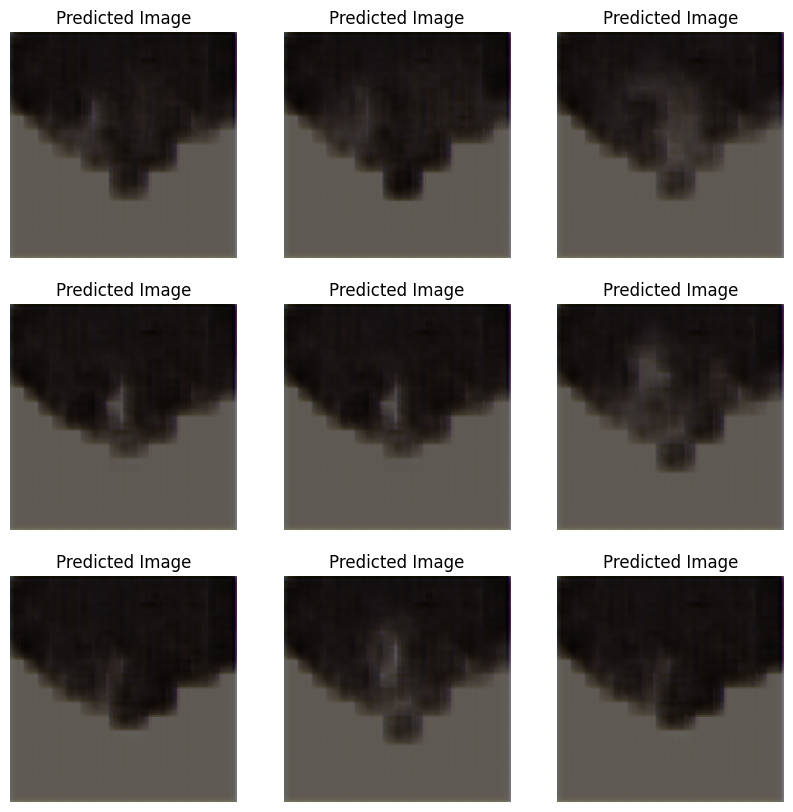

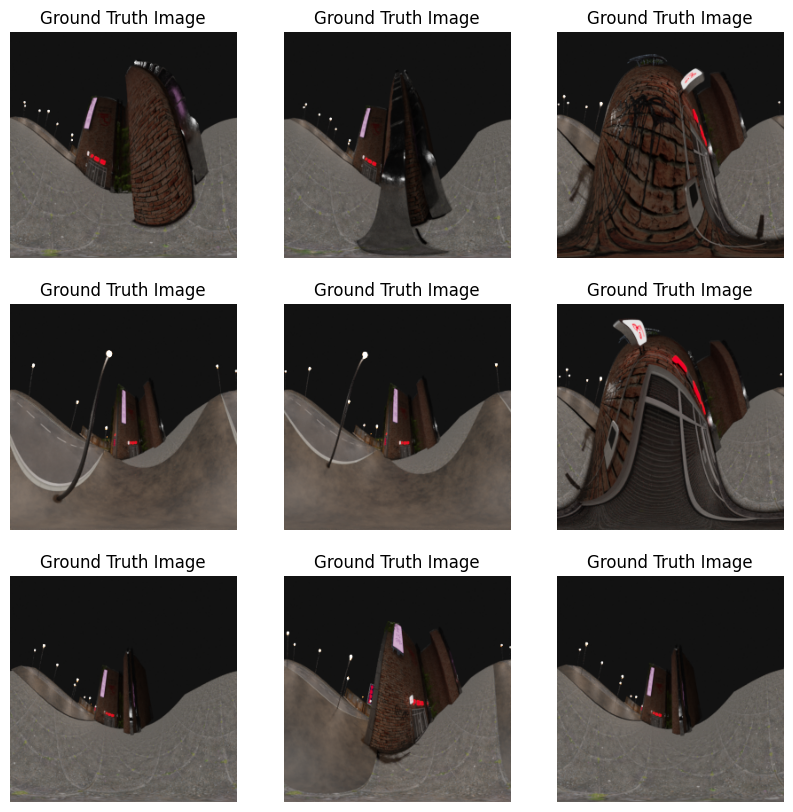

In [23]:

# Predict the interpolated images
predicted_images = model_depth.predict([barycentric_test, images_test, depth_images_test])

# Plot the predicted and ground truth images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(predicted_images[i])
    plt.axis('off')
    plt.title('Predicted Image')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_ground_truth_test[i])
    plt.axis('off')
    plt.title('Ground Truth Image')
plt.show()


In [24]:
# save the model 
model_file_path = 'depth_model.h5'

# Save the model
model_depth.save(model_file_path)

print("Model saved successfully at:", model_file_path)

Model saved successfully at: depth_model.h5


In [22]:
from keras import layers, models

def build_interpolation_model(input_shape):
    # Input layers
    input_coords = layers.Input(shape=(3,))
    input_images_rgb = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    input_images_depth = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
    # Concatenate RGB and Depth images along the channel dimension
    input_images_concat = layers.Concatenate()([input_images_rgb, input_images_depth])


    # Reshape the images so that they are one after the other in a vector of shape (
    input_images_concat_reshaped = layers.Reshape((256, 256, 18))(input_images_concat)

    # Image Processing Branch
    conv_output = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(input_images_concat_reshaped)
    conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
    conv_output = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
    conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
    conv_output = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
    conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
    conv_output = layers.Flatten()(conv_output)

    # Barycentric Coordinates Processing Branch
    x = layers.Dense(64, activation='relu')(input_coords)
    x = layers.Dense(32, activation='relu')(x)

    # Concatenate Barycentric Coordinates with the input images
    merged_input = layers.Concatenate()([conv_output, x])
    
    # Interpolation
    x = layers.Dense(1024, activation='relu')(merged_input)
    x = layers.Reshape((16, 16, 4))(x)  # Change to 4 channels
    x = layers.Conv2DTranspose(filters=512, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=32, kernel_size=(4, 4), activation='relu', strides=(1, 1), padding='same')(x)
    x = layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), activation='linear', strides=(1, 1), padding='same')(x)

    # Output
    output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
    # Creating model
    model = models.Model(inputs=[input_coords, input_images_rgb, input_images_depth], outputs=output)
    return model

image_height, image_width, num_channels = 256, 256, 3

input_shape = (3, image_height, image_width, num_channels)
combined_model = build_interpolation_model(input_shape)


combined_model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_32      │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 3, 256,    │          0 │ input_layer_31[0… │
│ (Concatenate)       │ 256, 6)           │            │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, 256, 256,  │          0 │ concatenate_21[0… │
│ (Reshape)           │ 18)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 256, 256,  │     36,992 │ reshape_18[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_48    │ (None, 128, 128,  │          0 │ conv2d_56[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │    524,544 │ max_pooling2d_48… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_49    │ (None, 64, 64,    │          0 │ conv2d_57[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 64,    │  2,097,664 │ max_pooling2d_49… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_30      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_50    │ (None, 32, 32,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │        256 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 524288)    │          0 │ max_pooling2d_50… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 32)        │      2,080 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 524320)    │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1024)      │ 536,904,7… │ concatenate_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_19          │ (None, 16, 16, 4) │          0 │ dense_30[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_51 │ (None, 32, 32,    │     33,280 │ reshape_19[0][0]

 Total params: 542,386,966 (2.02 GB)

 Trainable params: 542,386,966 (2.02 GB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from keras import layers, models

def build_new(input_shape):
    # Input layers
    input_coords = layers.Input(shape=(3,))
    input_images_rgb = layers.Input(shape=input_shape)  # Shape (None, image_depth, image_height, image_width, num_channels)
    input_images_depth = layers.Input(shape=input_shape)  # Shape (None, image_depth, image_height, image_width, num_channels)
    
    # Concatenate RGB and Depth images along the channel dimension
    input_images_concat = layers.Concatenate(axis=-1)([input_images_rgb, input_images_depth])   

    # Image Processing Branch
    conv_output = layers.Conv3D(filters=128, kernel_size=(4, 4, 4), activation='relu', padding='same')(input_images_concat)
    conv_output = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_output)
    conv_output = layers.Conv3D(filters=256, kernel_size=(4, 4, 4), activation='relu', padding='same')(conv_output)
    conv_output = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_output)
    conv_output = layers.Conv3D(filters=512, kernel_size=(4, 4, 4), activation='relu', padding='same')(conv_output)
    conv_output = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_output)
    conv_output = layers.Flatten()(conv_output)

    # Barycentric Coordinates Processing Branch
    x = layers.Dense(64, activation='relu')(input_coords)
    x = layers.Dense(32, activation='relu')(x)

    # Concatenate Barycentric Coordinates with the input images
    merged_input = layers.Concatenate()([conv_output, x])
    
    # Interpolation: we need output of shape (256, 256, 3)
    x = layers.Dense(1024, activation='relu')(merged_input)
    x = layers.Reshape((16, 16, 4))(x)  # Change to 4 channels
    x = layers.Conv2DTranspose(filters=512, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=32, kernel_size=(4, 4), activation='relu', strides=(1, 1), padding='same')(x)
    x = layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), activation='linear', strides=(1, 1), padding='same')(x)


    output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
    # Creating model
    model = models.Model(inputs=[input_coords, input_images_rgb, input_images_depth], outputs=output)
    return model

image_height, image_width, num_channels = 256, 256, 3

input_shape = (3, image_height, image_width, num_channels)
test_model = build_new(input_shape)


test_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 3, 256,    │          0 │ input_layer_25[0… │
│ (Concatenate)       │ 256, 6)           │            │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 3, 256,    │     49,280 │ concatenate_16[0… │
│                     │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_18    │ (None, 1, 128,    │          0 │ conv3d_19[0][0]   │
│ (MaxPooling3D)      │ 128, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 1, 128,    │  2,097,408 │ max_pooling3d_18… │
│                     │ 128, 256)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_19    │ (None, 0, 64, 64, │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 0, 64, 64, │  8,389,120 │ max_pooling3d_19… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_20    │ (None, 0, 32, 32, │          0 │ conv3d_21[0][0]   │
│ (MaxPooling3D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │        256 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 0)         │          0 │ max_pooling3d_20… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 32)        │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1024)      │     33,792 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 16, 16, 4) │          0 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_17 │ (None, 32, 32,    │     33,280 │ reshape_9[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_18 │ (None, 64, 64,    │  2,097,408 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 256)              │            │                 

 Total params: 13,392,662 (51.09 MB)

 Trainable params: 13,392,662 (51.09 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from keras import config, callbacks

# Train the model
num_epochs = 15
batch_size = 32

callback = callbacks.EarlyStopping(monitor='loss', patience=3)

combined_model.compile(
    optimizer= 'adam',
    loss='mse',
    metrics=[
        'MeanSquaredError',
    ]
)
combined_model.fit([barycentric_train, images_train, depth_images_train], images_ground_truth_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val, depth_images_val], images_ground_truth_val), callbacks=[callback])

# evaluate the model
loss = combined_model.evaluate([barycentric_test, images_test, depth_images_test], images_ground_truth_test)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 123s 20s/step - MeanSquaredError: 0.1046 - loss: 0.1046 - val_MeanSquaredError: 0.0965 - val_loss: 0.0965
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 114s 18s/step - MeanSquaredError: 0.0757 - loss: 0.0757 - val_MeanSquaredError: 0.0113 - val_loss: 0.0113
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 110s 18s/step - MeanSquaredError: 0.0106 - loss: 0.0106 - val_MeanSquaredError: 0.0086 - val_loss: 0.0086
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 118s 20s/step - MeanSquaredError: 0.0084 - loss: 0.0084 - val_MeanSquaredError: 0.0075 - val_loss: 0.0075
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 124s 21s/step - MeanSquaredError: 0.0074 - loss: 0.0074 - val_MeanSquaredError: 0.0064 - val_loss: 0.0064
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 123s 20s/step - MeanSquaredError: 0.0065 - loss: 0.0065 - val_MeanSquaredError: 0.0062 - val_loss: 0.0062
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 124s 21s/step - MeanSquaredError: 0.0062 - loss: 0.0062 - val_MeanSquaredError: 0.0059 - val_loss: 0.0059
Epoch 

In [20]:
from keras import config, callbacks

# Train the model
num_epochs = 15
batch_size = 32

callback = callbacks.EarlyStopping(monitor='loss', patience=3)

test_model.compile(
    optimizer= 'adam',
    loss='mse',
    metrics=[
        'MeanSquaredError',
    ]
)
test_model.fit([barycentric_train, images_train, depth_images_train], images_ground_truth_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val, depth_images_val], images_ground_truth_val), callbacks=[callback])

# evaluate the model
loss = test_model.evaluate([barycentric_test, images_test, depth_images_test], images_ground_truth_test)

Epoch 1/15


ValueError: Exception encountered when calling MaxPooling3D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_13_1/max_pooling3d_19_1/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1]](functional_13_1/conv3d_20_1/Relu)' with input shapes: [?,1,128,128,256].[0m

Arguments received by MaxPooling3D.call():
  • inputs=tf.Tensor(shape=(None, 1, 128, 128, 256), dtype=float32)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


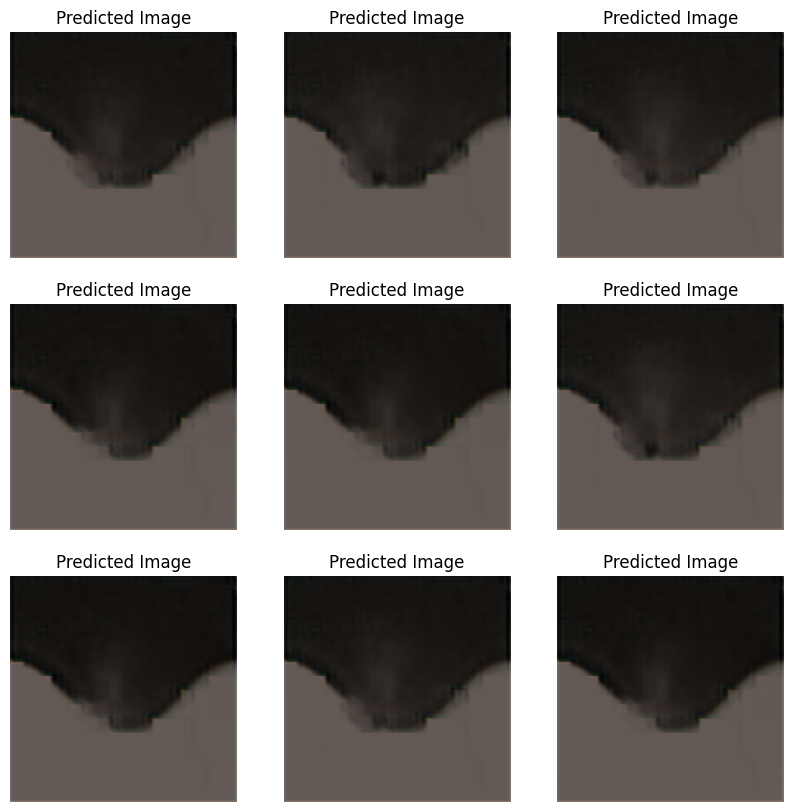

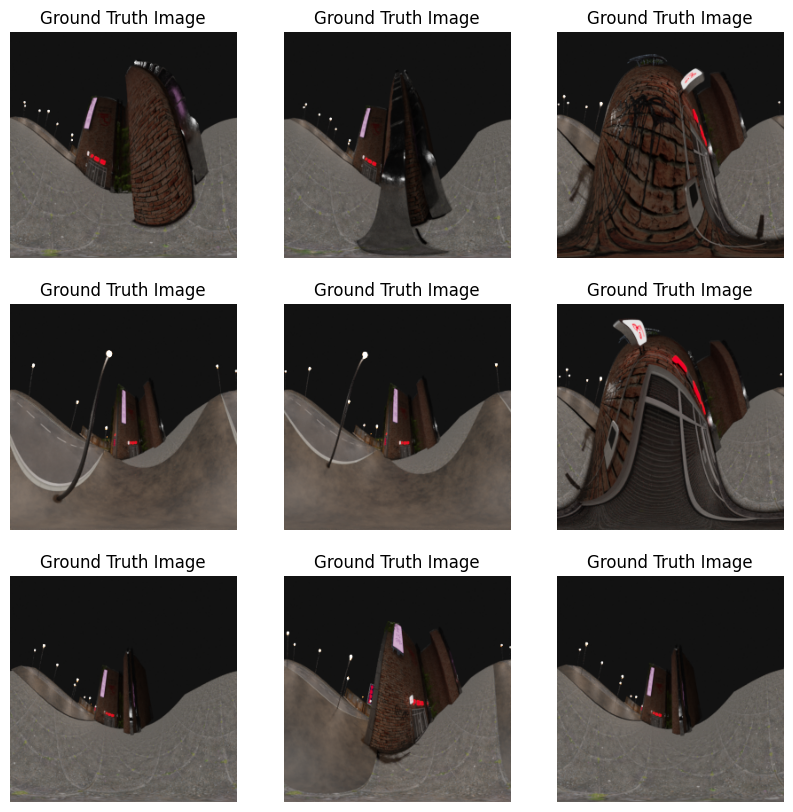

In [24]:

# Predict the interpolated images
predicted_images = combined_model.predict([barycentric_test, images_test, depth_images_test])

# Plot the predicted and ground truth images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(predicted_images[i])
    plt.axis('off')
    plt.title('Predicted Image')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_ground_truth_test[i])
    plt.axis('off')
    plt.title('Ground Truth Image')
plt.show()


In [29]:
# save the model 
model_file_path = 'combined_model.h5'

# Save the model
combined_model.save(model_file_path)

print("Model saved successfully at:", model_file_path)

Model saved successfully at: combined_model.h5
